In [1]:
using Pkg
Pkg.activate("@__DIR__")
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV

### 1. Generate Random Data

Let's start by generating some random imbalanced data. Here we generate data where there are three classes `0, 1, 2` that occur with probability `0.5, 0.2, 0.3` respectively, making `0` the majority class. The data has `4` continuous features and `4` categorical features where the categorical variables have `3, 4, 2, 5` unique values respectively.

In [2]:
rng = Random.default_rng()

num_rows = 100
num_cont_feats = 4
probs = [0.5, 0.2, 0.3]

cat_feats_num_vals = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; probs, cat_feats_num_vals)
X = DataFrame(X)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0100484,0.182746,0.438453,0.379198,3.0,1.0,2.0,2.0
2,0.479035,0.150035,0.0628313,0.0984673,3.0,3.0,2.0,1.0
3,0.608656,0.814101,0.498613,0.0755542,1.0,2.0,1.0,2.0
4,0.271109,0.938893,0.824951,0.466024,2.0,3.0,2.0,2.0
5,0.254079,0.398297,0.0761111,0.172457,2.0,4.0,2.0,4.0
6,0.910313,0.0749411,0.556802,0.644977,3.0,4.0,1.0,3.0
7,0.88353,0.890743,0.39297,0.774518,2.0,4.0,2.0,3.0
8,0.131727,0.950167,0.665143,0.286517,1.0,1.0,1.0,3.0
9,0.327435,0.473396,0.956158,0.303201,1.0,1.0,1.0,5.0


We follow by coercing the columns with few values (i.e., the categorical ones) to the appropriate type (a finite `sci-type` such as `OrderedFactor` or `Multiclass`). This is necessary because the `SMOTE-NC` assumes that all categorical features have `sci-type` finite.

In [3]:
X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,0.0100484,0.182746,0.438453,0.379198,3.0,1.0,2.0,2.0
2,0.479035,0.150035,0.0628313,0.0984673,3.0,3.0,2.0,1.0
3,0.608656,0.814101,0.498613,0.0755542,1.0,2.0,1.0,2.0
4,0.271109,0.938893,0.824951,0.466024,2.0,3.0,2.0,2.0
5,0.254079,0.398297,0.0761111,0.172457,2.0,4.0,2.0,4.0
6,0.910313,0.0749411,0.556802,0.644977,3.0,4.0,1.0,3.0
7,0.88353,0.890743,0.39297,0.774518,2.0,4.0,2.0,3.0
8,0.131727,0.950167,0.665143,0.286517,1.0,1.0,1.0,3.0
9,0.327435,0.473396,0.956158,0.303201,1.0,1.0,1.0,5.0


### 2. Apply SMOTE-NC

#### Using Imbalance Only

Applying SMOTE-NC using the standard API is very straightforward. There are two main hyperparameters which are the number of nearest neighbors `k` and the wanted ratios of each class relative to the majority class `ratios`. In the example below, we want all three classes to have `120%` of the data that was present in the majority class (i.e., class `0` prior to applying the algorithm)

In [4]:
Xover, yover = smotenc(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  class:  0


(174×8 DataFrame
 Row │ Column1    Column2    Column3    Column4    Column5  Column6  Column7   ⋯
     │ Float64    Float64    Float64    Float64    Cat…     Cat…     Cat…      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0100484  0.182746   0.438453   0.379198   3.0      1.0      2.0       ⋯
   2 │ 0.479035   0.150035   0.0628313  0.0984673  3.0      3.0      2.0
   3 │ 0.608656   0.814101   0.498613   0.0755542  1.0      2.0      1.0
   4 │ 0.271109   0.938893   0.824951   0.466024   2.0      3.0      2.0
   5 │ 0.254079   0.398297   0.0761111  0.172457   2.0      4.0      2.0       ⋯
   6 │ 0.910313   0.0749411  0.556802   0.644977   3.0      4.0      1.0
   7 │ 0.88353    0.890743   0.39297    0.774518   2.0      4.0      2.0
   8 │ 0.131727   0.950167   0.665143   0.286517   1.0      1.0      1.0
  ⋮  │     ⋮          ⋮          ⋮          ⋮         ⋮        ⋮        ⋮      ⋱
 168 │ 0.257824   0.391734   0.0727219  0.292076   3.0     

#### Using MLJ

To use `MLJ`, we first instantiate the model using keyword parameters, wrap it in a machine and the transform the machine with our input data `X,y`.

In [5]:
smotenc_model = Imbalance.MLJ.SMOTENC(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)

(174×8 DataFrame
 Row │ Column1    Column2    Column3    Column4    Column5  Column6  Column7   ⋯
     │ Float64    Float64    Float64    Float64    Cat…     Cat…     Cat…      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0100484  0.182746   0.438453   0.379198   3.0      1.0      2.0       ⋯
   2 │ 0.479035   0.150035   0.0628313  0.0984673  3.0      3.0      2.0
   3 │ 0.608656   0.814101   0.498613   0.0755542  1.0      2.0      1.0
   4 │ 0.271109   0.938893   0.824951   0.466024   2.0      3.0      2.0
   5 │ 0.254079   0.398297   0.0761111  0.172457   2.0      4.0      2.0       ⋯
   6 │ 0.910313   0.0749411  0.556802   0.644977   3.0      4.0      1.0
   7 │ 0.88353    0.890743   0.39297    0.774518   2.0      4.0      2.0
   8 │ 0.131727   0.950167   0.665143   0.286517   1.0      1.0      1.0
  ⋮  │     ⋮          ⋮          ⋮          ⋮         ⋮        ⋮        ⋮      ⋱
 168 │ 0.257824   0.391734   0.0727219  0.292076   3.0     

#### Using TableTransforms

Let's consider an example with table transforms on a more realistic dataset. This time the categorical variables are strings so all we had to do is coerce `strings`to the `multiclass` type. `smotenc` will take of encoding them and decoding them before and after applying the actual algorithm.

In [15]:
# For TableTransforms
Xy = CSV.read("../datasets/churn.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,Cat…,Int64,Cat…,Cat…,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,France,Female,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,Spain,Female,43,2,1.25511e5,1,1,1,79084.1,0
6,6,15574012,Chu,645,Spain,Male,44,8,1.13756e5,2,1,0,1.49757e5,1
7,7,15592531,Bartlett,822,France,Male,50,7,0.0,2,1,1,10062.8,0
8,8,15656148,Obinna,376,Germany,Female,29,4,1.15047e5,4,1,0,1.19347e5,1
9,9,15792365,He,501,France,Male,44,4,1.42051e5,2,0,1,74940.5,0


Now we instantiate the model and simply pass the data to it using the pipeline operator `\>`. This is equivalent to calling `apply` from table transforms.

In [14]:
using Imbalance: TableTransforms.SMOTENC
y_ind = 14
smote_model_t = SMOTENC(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Cat…,Float64,Cat…,Cat…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.56346e7,Hargrave,619.0,France,Female,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1.0
2,2.0,1.56473e7,Hill,608.0,Spain,Female,41.0,1.0,83807.9,1.0,0.0,1.0,1.12543e5,0.0
3,3.0,1.56193e7,Onio,502.0,France,Female,42.0,8.0,1.59661e5,3.0,1.0,0.0,1.13932e5,1.0
4,4.0,1.57014e7,Boni,699.0,France,Female,39.0,1.0,0.0,2.0,0.0,0.0,93826.6,0.0
5,5.0,1.57379e7,Mitchell,850.0,Spain,Female,43.0,2.0,1.25511e5,1.0,1.0,1.0,79084.1,0.0
6,6.0,1.5574e7,Chu,645.0,Spain,Male,44.0,8.0,1.13756e5,2.0,1.0,0.0,1.49757e5,1.0
7,7.0,1.55925e7,Bartlett,822.0,France,Male,50.0,7.0,0.0,2.0,1.0,1.0,10062.8,0.0
8,8.0,1.56561e7,Obinna,376.0,Germany,Female,29.0,4.0,1.15047e5,4.0,1.0,0.0,1.19347e5,1.0
9,9.0,1.57924e7,He,501.0,France,Male,44.0,4.0,1.42051e5,2.0,0.0,1.0,74940.5,0.0


In [19]:
Xy, _ = generate_imbalanced_data(
    50,
    4;
    probs = [0.25, 0.5, 0.25],
    cat_feats_num_vals = [4, 3, 5],
    type = "ColTable",
    insert_y = 5,
    rng = 42,
)

((Column1 = [0.10083458248601018, 0.32106572972106817, 0.9695150609084499, 0.012898301755861596, 0.7555027304121053, 0.3467415729179013, 0.35969402837473463, 0.2601876747805505, 0.9153753178220317, 0.907410564584128  …  0.12897177983538477, 0.6863866635957644, 0.9452279486233184, 0.6135953031731222, 0.7393683025755258, 0.49776424409145725, 0.6193417397007426, 0.363826187287986, 0.7584295856669816, 0.2184451048446261], Column2 = [0.3895982138874483, 0.08174960438833156, 0.6636644264313925, 0.7304405732047541, 0.027800141050299598, 0.20874452928568255, 0.5612819555303167, 0.5693791212655085, 0.2787942224536374, 0.5598733934174821  …  0.4479438784027816, 0.23004681363952995, 0.021532597906190776, 0.8482825697641306, 0.10773487816863903, 0.32189982199036116, 0.9651330791713363, 0.18080927897651633, 0.2907506630258835, 0.36872799387588473], Column3 = [0.061489791166806085, 0.45645058368583713, 0.06546916714160167, 0.7243956502957003, 0.6566078046100849, 0.6612680221549533, 0.112262181144075

In [20]:
smote_model_t = SMOTENC(5, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00


(Column1 = [0.10083458248601018, 0.32106572972106817, 0.9695150609084499, 0.012898301755861596, 0.7555027304121053, 0.3467415729179013, 0.35969402837473463, 0.2601876747805505, 0.9153753178220317, 0.907410564584128  …  0.6512503623962402, 0.43938079476356506, 0.35336217284202576, 0.9307571053504944, 0.3239823579788208, 0.6406140327453613, 0.7907325029373169, 0.6517559885978699, 0.14128701388835907, 0.4340895712375641],
 Column2 = [0.3895982138874483, 0.08174960438833156, 0.6636644264313925, 0.7304405732047541, 0.027800141050299598, 0.20874452928568255, 0.5612819555303167, 0.5693791212655085, 0.2787942224536374, 0.5598733934174821  …  0.4188659191131592, 0.45808666944503784, 0.36915263533592224, 0.22698132693767548, 0.5029253363609314, 0.06811249256134033, 0.26898476481437683, 0.4194771647453308, 0.39846253395080566, 0.6089785695075989],
 Column3 = [0.061489791166806085, 0.45645058368583713, 0.06546916714160167, 0.7243956502957003, 0.6566078046100849, 0.6612680221549533, 0.1122621811440

### 3. Plot the Results

We can finally plot the data before and after to validate the results.

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/Manifest.toml`


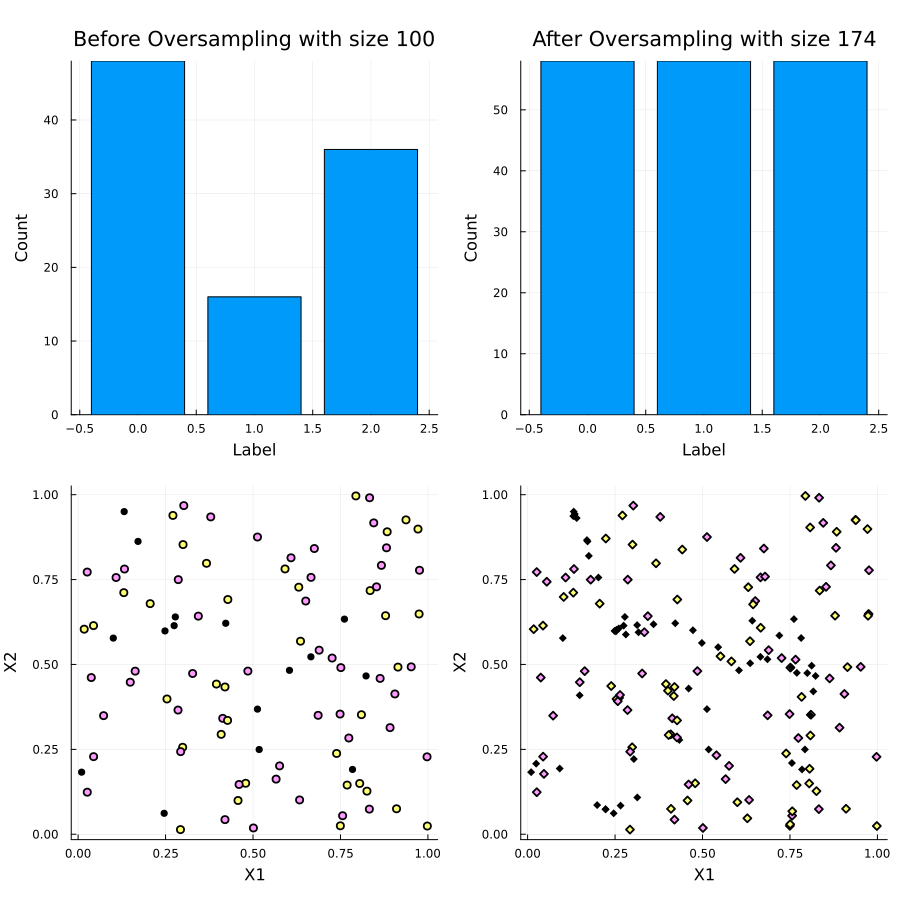

In [16]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)